In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from skimage import io

%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 16, 10

np.random.seed(42)


In [3]:
frame = 0
print(f"{frame:06d}")

000000


In [4]:
root_dir = Path().cwd().parent
data_dir = root_dir / "data"
(data_dir/"interim").mkdir(parents=True, exist_ok=True)


In [5]:
data_names = [
    "frame",
    "track_id",
    "type",
    "truncated",
    "occluded",
    "alpha",
    "bbox_left",
    "bbox_top",
    "bbox_right",
    "bbox_bottom",
    "dimension_width",
    "dimension_height",
    "dimension_length",
    "location_x",
    "location_y",
    "location_z",
    "rotation_y",
]
df = pd.read_csv(
    data_dir / "raw/KITTI/data_tracking_label_2/training/label_02/0000.txt", delimiter=" ", names=data_names, index_col=False
)

df.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,dimension_width,dimension_height,dimension_length,location_x,location_y,location_z,rotation_y
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245


In [6]:
df1 = df[df['type'].isin(['Car', 'Pedestrian', 'Cyclist'])]
df1.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,dimension_width,dimension_height,dimension_length,location_x,location_y,location_z,rotation_y
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456
9,1,2,Pedestrian,0,0,-2.530402,1138.342096,160.872449,1223.338201,324.146788,1.714062,0.767881,0.972283,6.352093,1.593046,8.156156,-1.886840
13,2,1,Cyclist,0,0,-1.933364,752.406083,151.248515,946.562490,374.000000,1.739063,0.824591,1.785241,1.760880,1.605178,5.780931,-1.653453


(-0.5, 1241.5, 374.5, -0.5)

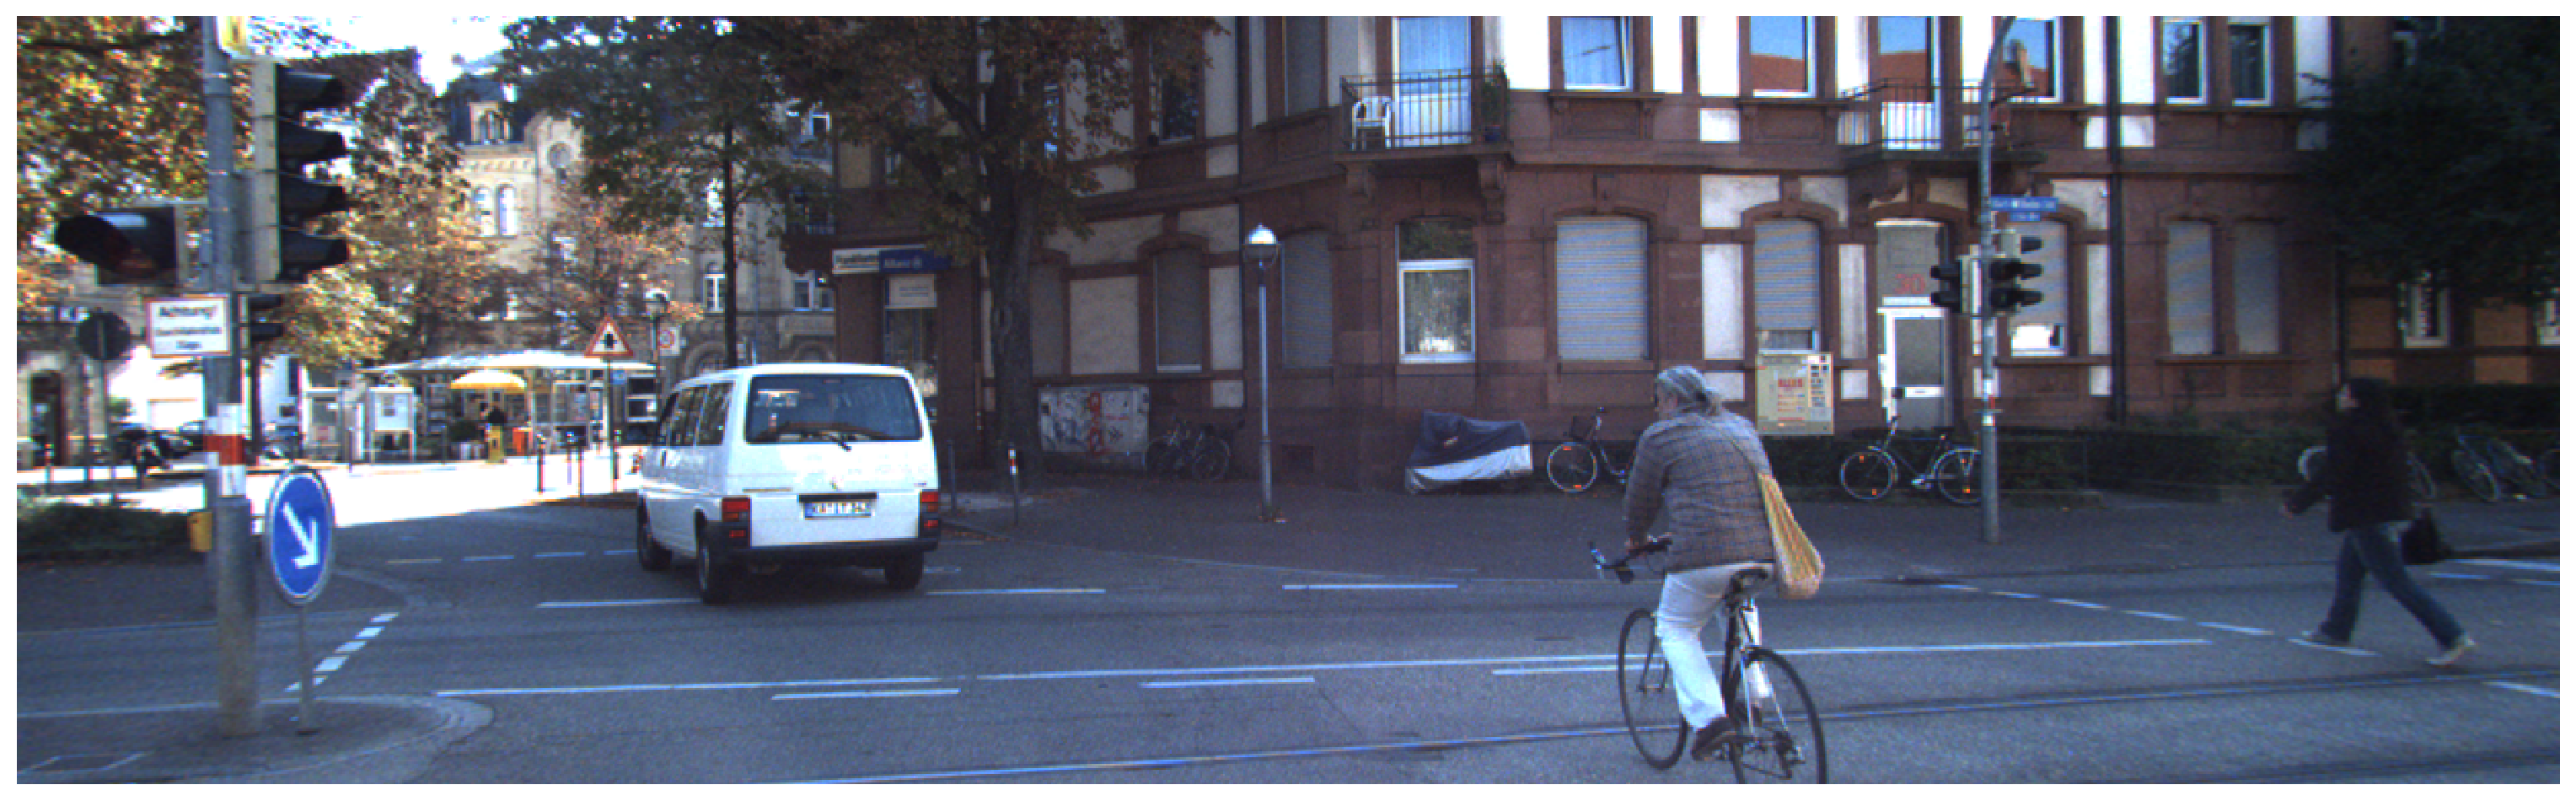

In [7]:
img = io.imread(data_dir / f"raw/KITTI/data_tracking_image_2/training/label_02/0000/{frame:06d}.png")
io.imshow(img)

# Hide grid lines
plt.grid(False)
plt.axis('off')

# io.show()

In [8]:
df2 = df1[df1['frame'].isin([frame])]
df2.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,dimension_width,dimension_height,dimension_length,location_x,location_y,location_z,rotation_y
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245


In [9]:


for index, row in df2.iterrows():
    # row = df1.iloc[0]
    print(row)
    print(row["type"])
    print("")

    match row["type"]:
        case "Cyclist"  :
            frame_color = (255, 0, 0)

        case "Car"  :
            frame_color = (0, 255, 0)

        case "Pedestrian"  :
            frame_color = (0, 0, 255)

    img = cv2.rectangle(
        img,
        (int(row["bbox_left"]), int(row["bbox_top"])),
        (int(row["bbox_right"]), int(row["bbox_bottom"])),
        color=frame_color,
        thickness=row["truncated"],
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        row["type"], fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1.75, thickness=2
    )

    img = cv2.rectangle(
        img,
        (int(row["bbox_left"]), int(row["bbox_top"])),
        (
            int(row["bbox_left"] + label_width + label_width * 0.05),
            int(row["bbox_top"] + label_height + label_height * 0.25),
        ),
        color=frame_color,
        thickness=cv2.FILLED,
    )

    img = cv2.putText(
        img,
        row["type"],
        org=(
            int(row["bbox_left"]),
            int(row["bbox_top"] + label_height + label_height * 0.25),
        ),  # bottom left
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75,
        color=(255, 255, 255),
        thickness=2,
    )


frame                        0
track_id                     1
type                   Cyclist
truncated                    0
occluded                     0
alpha                -1.936993
bbox_left           737.619499
bbox_top            161.531951
bbox_right          931.112229
bbox_bottom              374.0
dimension_width       1.739063
dimension_height      0.824591
dimension_length      1.785241
location_x              1.6404
location_y             1.67566
location_z            5.776261
rotation_y           -1.675458
Name: 3, dtype: object
Cyclist

frame                         0
track_id                      2
type                 Pedestrian
truncated                     0
occluded                      0
alpha                 -2.523309
bbox_left           1106.137292
bbox_top             166.576807
bbox_right          1204.470628
bbox_bottom          323.876144
dimension_width        1.714062
dimension_height       0.767881
dimension_length       0.972283
location_x             6.

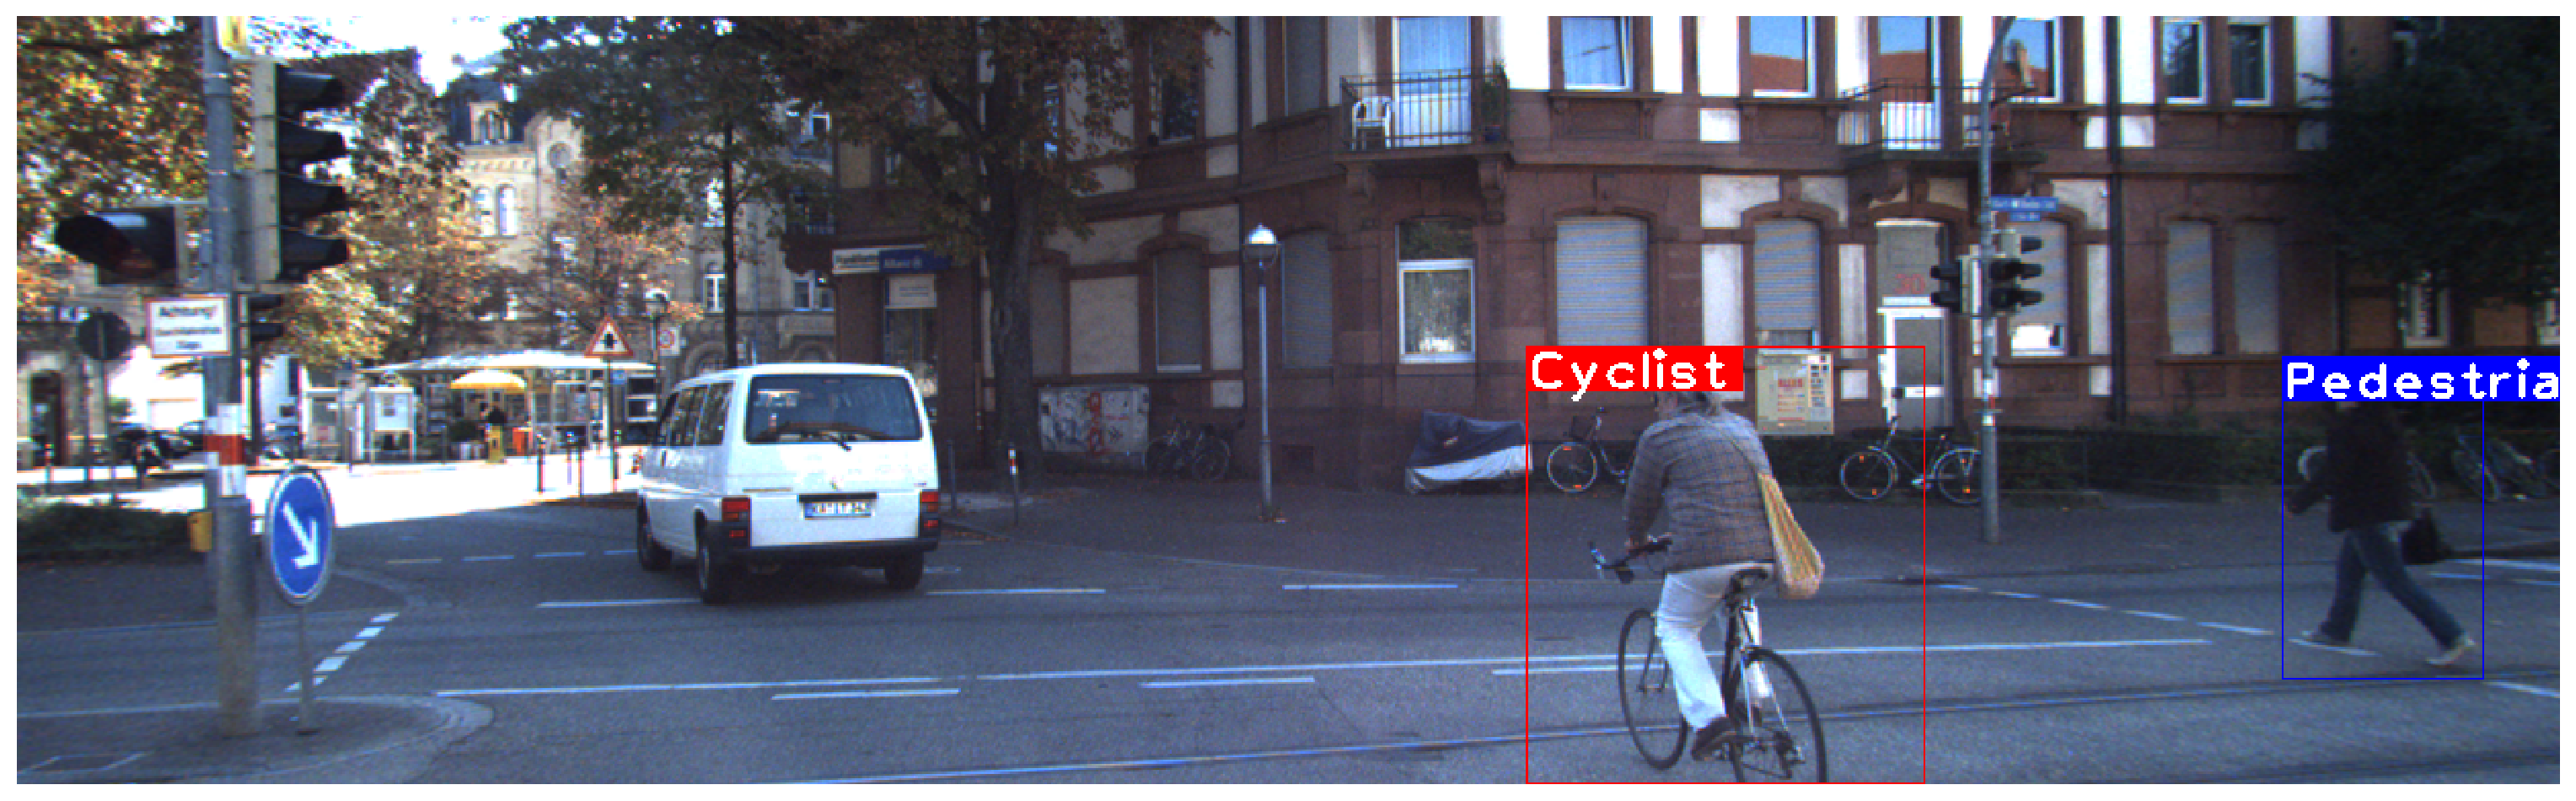

In [10]:
io.imshow(img)

# Hide grid lines
plt.grid(False)
plt.axis('off')


io.show()